## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB03.ipynb**, failure to do so will incur in a **lower grade**.

In [1]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt


1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.


In [2]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [31]:
ID = 1234453
np.random.seed(ID)

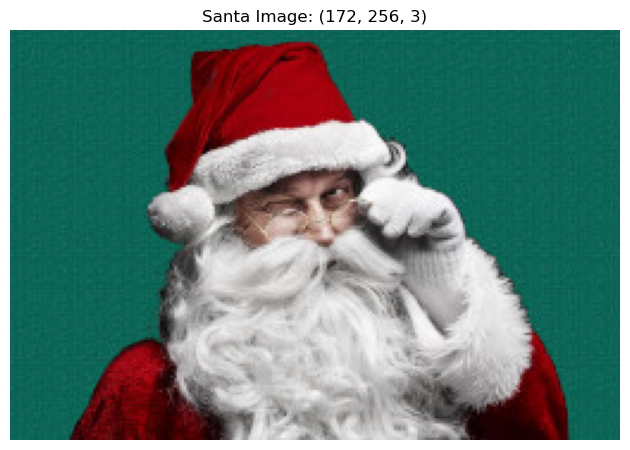

In [32]:
# To load the images use the function plt.imread(<path_to_iamge>)
santa_image = plt.imread(".\data\santaclaus2.jpg")
# Plot the images with their shapes
# Sugestion: use the function img_plot()
img_plot(santa_image, title="Santa Image")

In [33]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)

santa_data = santa_image.reshape(-1, 3) / 255.0 
# Print the shape of the data and the min and max values of the pixels

print(f"Shape of the data: {santa_data.shape}")
print(f"Min value of pixels: {np.min(santa_data)}")
print(f"Max value of pixels: {np.max(santa_data)}")


Shape of the data: (44032, 3)
Min value of pixels: 0.0
Max value of pixels: 1.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

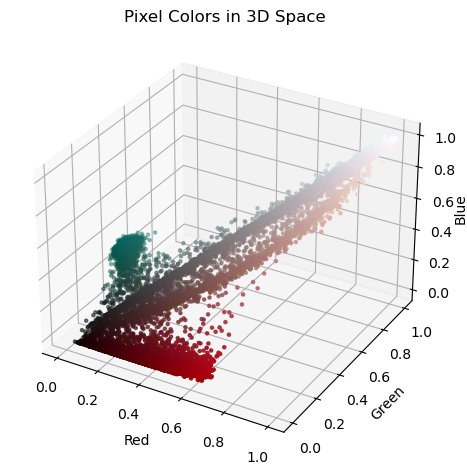

In [34]:
scatter_plot(santa_data, title="Pixel Colors in 3D Space")

In [42]:
import numpy as np
import typing as tp

def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    :return: centroids, clusters, error list
    """

    # Generate random initial centroids
    centroids = points[np.random.choice(range(len(points)), k, replace=False)]  
    error = []
    
    iters = 0
    while iters < max_iters:
        # Measure the distance to every centroid
        distances = np.linalg.norm(points[:, np.newaxis, :] - centroids, axis=2)
        # Assign all training data to the closest centroid
        clusters = np.argmin(distances, axis=1)
        
        # Calculate new centroids
        new_centroids = []
        for i in range(k):
            if len(points[clusters == i]) > 0:
                new_centroids.append(points[clusters == i].mean(axis=0))
            else:
                new_centroids.append(points[np.random.choice(range(len(points)), 1)])  # Random point if cluster is empty
        new_centroids = np.array(new_centroids)
        
        # Calculate error (total distance of points to their centroids)
        current_error = np.sum(np.min(distances, axis=1))
        error.append(current_error)
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        iters += 1

    return centroids, clusters, error


K-means Errors:
[17550.921258496397, 8016.449606229228, 7646.770824988918, 7522.056118293256, 7481.525523091697, 7472.559350835777, 7471.459339521116, 7472.6575393883195, 7473.990725151118, 7475.868668996474, 7476.830888413077, 7478.340056701701, 7478.424292681873, 7478.453909524862, 7478.97582112814, 7480.084474695407, 7480.004032376341, 7480.065670167783]


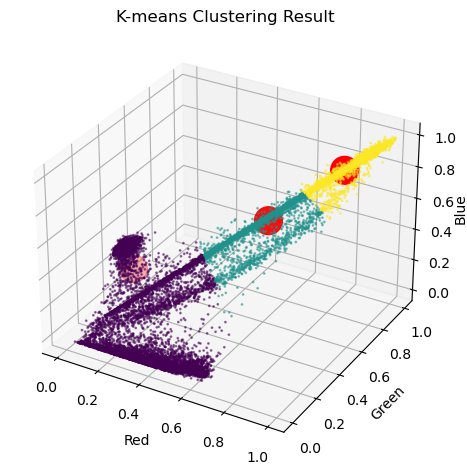

In [43]:
# Run your K-means function on the data
kmeans_centroids, kmeans_clusters, kmeans_errors = my_kmeans(santa_data, k=3)
# Print the errors:
print("K-means Errors:")
print(kmeans_errors)
# Plot the results
scatter_plot(santa_data, kmeans_clusters, kmeans_centroids, title="K-means Clustering Result")

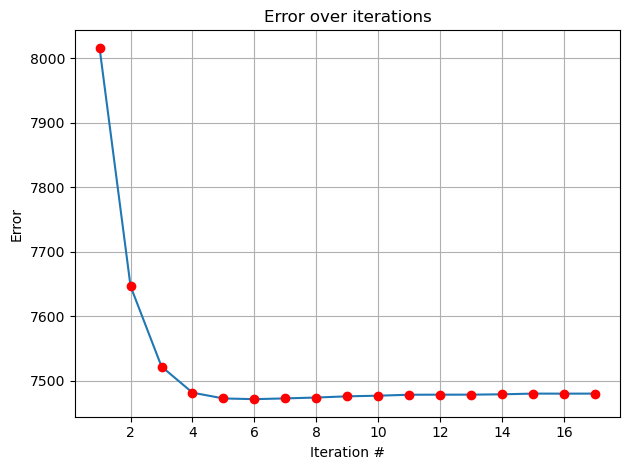

In [44]:
error_plot(kmeans_errors[1:], labels=range(1, len(kmeans_errors)))

In [45]:
# Define the K-means model
kmeans_sklearn = KMeans(n_clusters=3, n_init=10)  # You can adjust the number of initializations as needed
# Fit the model to the data
kmeans_sklearn.fit(santa_data)
# Get the cluster centers
kmeans_sklearn_centroids = kmeans_sklearn.cluster_centers_

Perform the same plot as above but with the output of the k-means function provided in sklearn.

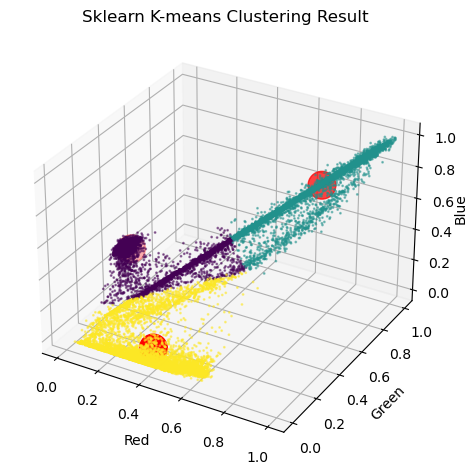

In [46]:
scatter_plot(santa_data, kmeans_sklearn.labels_, kmeans_sklearn_centroids, title="Sklearn K-means Clustering Result")

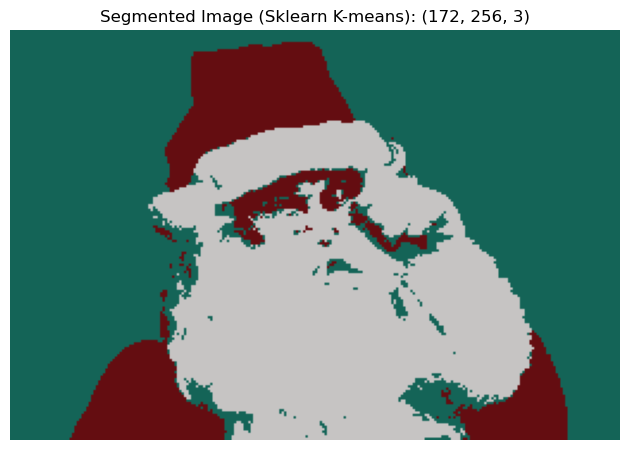

In [47]:
# Extarct the color values of the centers
colors_sklearn = np.clip(kmeans_sklearn_centroids, 0, 1)   # Rescale to [0, 255]
# Reshape the data to the original image shape
segmented_image_sklearn = colors_sklearn[kmeans_sklearn.labels_].reshape(santa_image.shape)
# Plot the recolored image
img_plot(segmented_image_sklearn, title="Segmented Image (Sklearn K-means)")

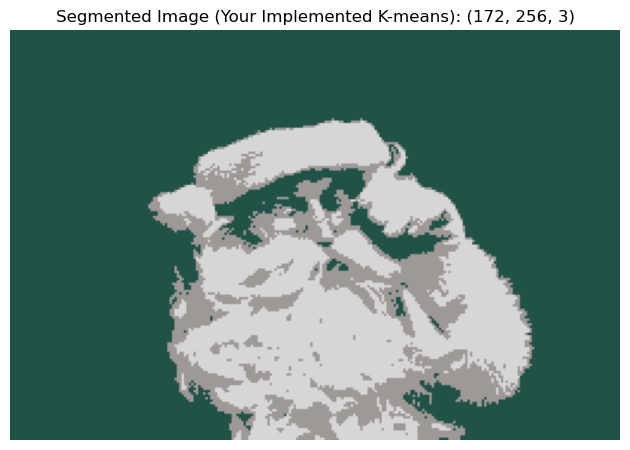

In [49]:
# Extarct the color values of the centers
colors_my_kmeans = np.clip(kmeans_centroids, 0, 1)  # Ensure values are within [0, 1]
# Reshape the data to the original image shape
segmented_image_my_kmeans = colors_my_kmeans[kmeans_clusters].reshape(santa_image.shape)
# Plot the recolored image
img_plot(segmented_image_my_kmeans, title="Segmented Image (Your Implemented K-means)")

Shape of the data: (19200, 3)
Min pixel value: 0
Max pixel value: 255

K-means clustering with different values of K (2-15):


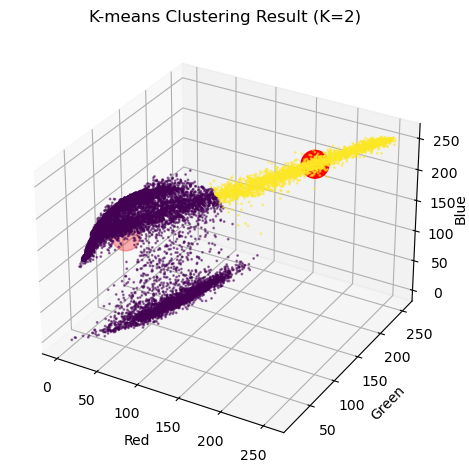

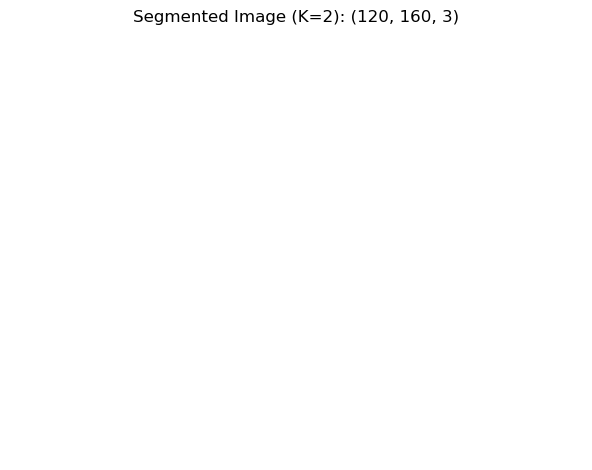

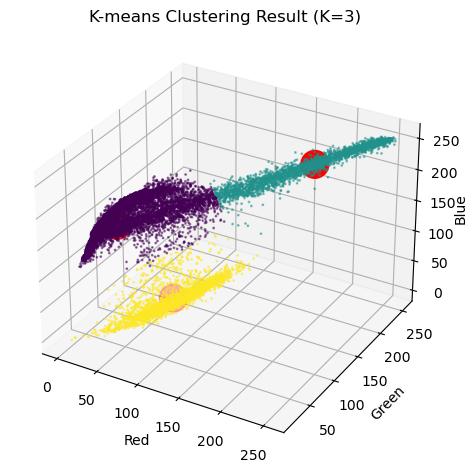

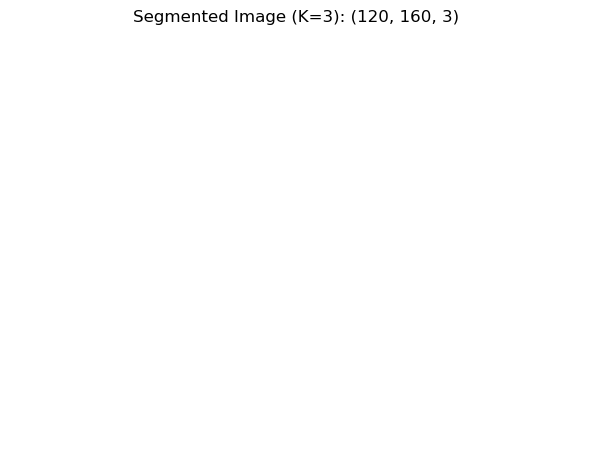

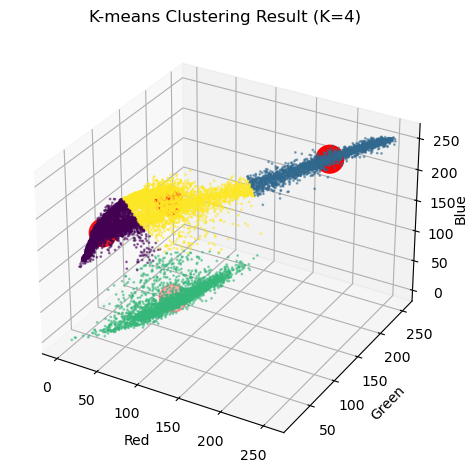

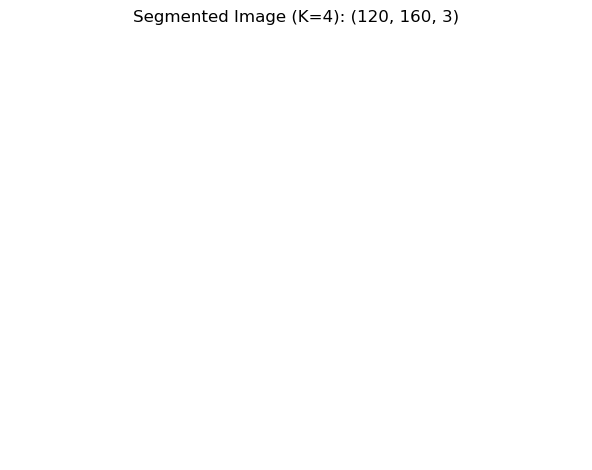

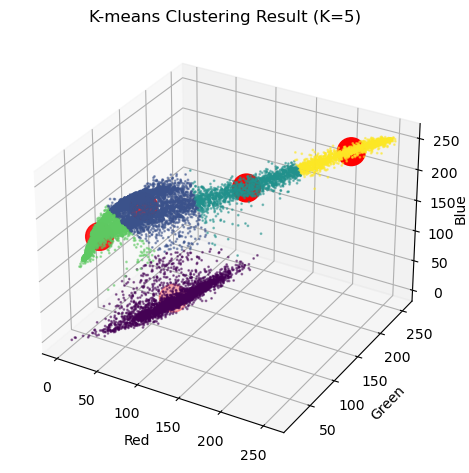

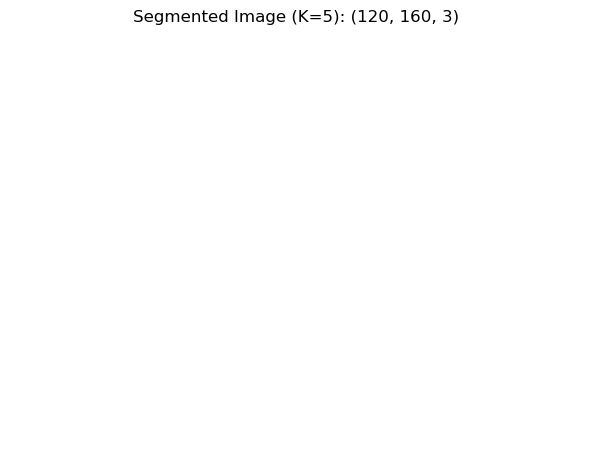

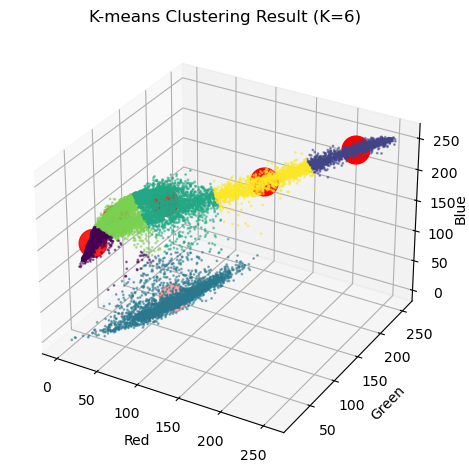

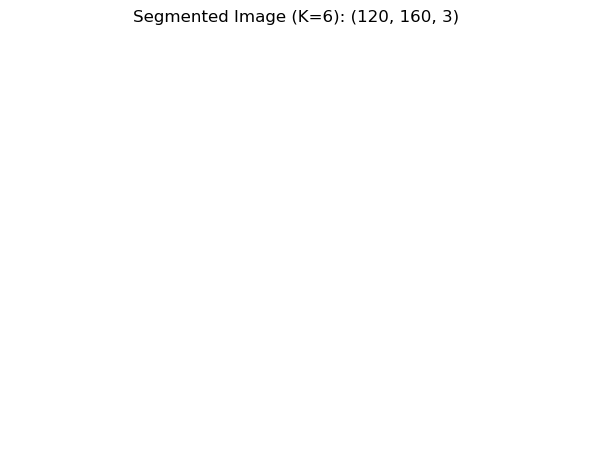

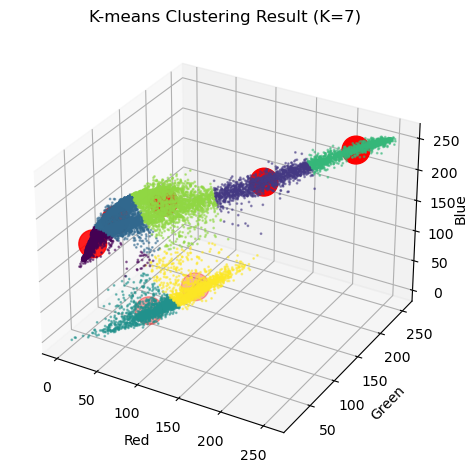

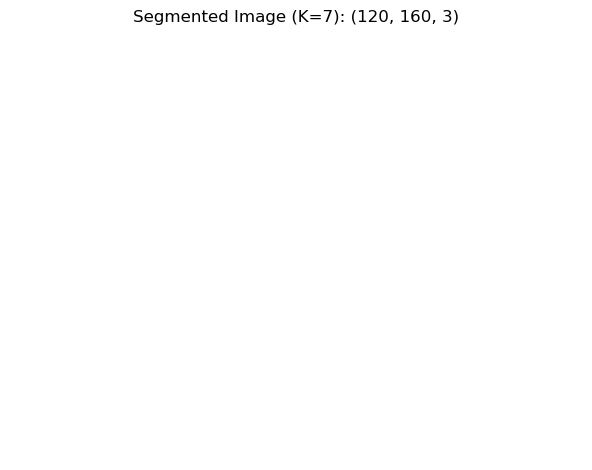

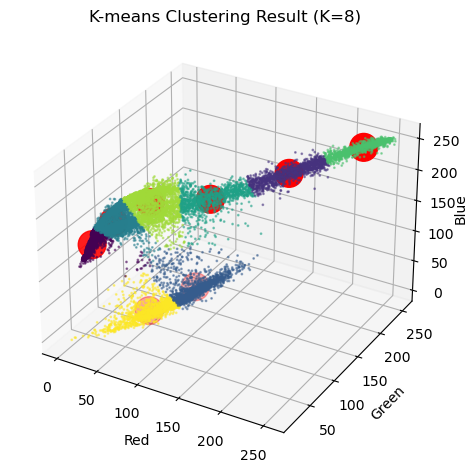

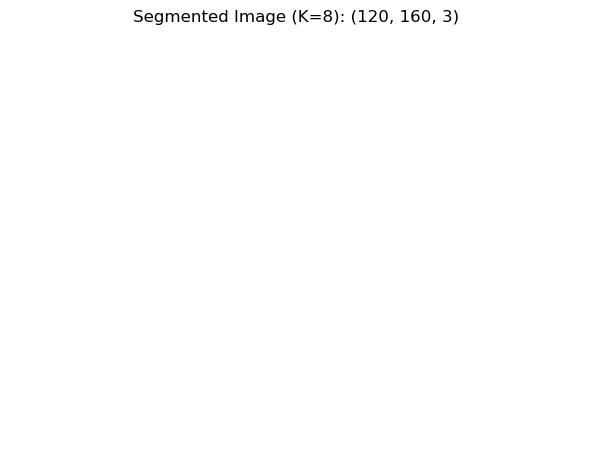

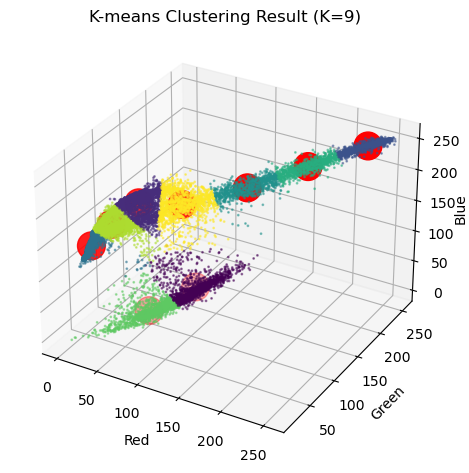

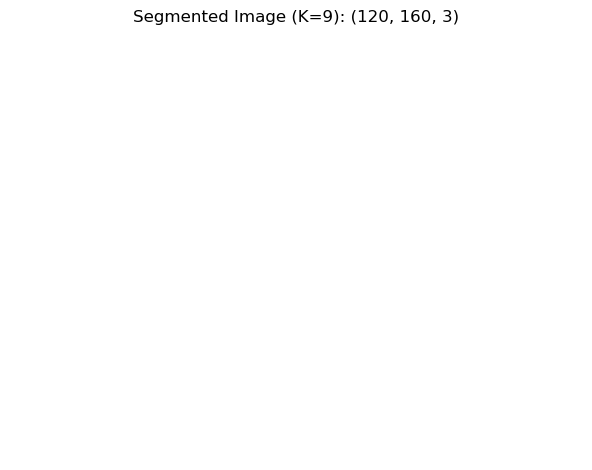

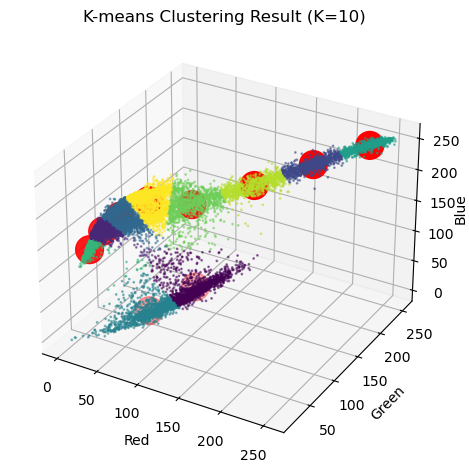

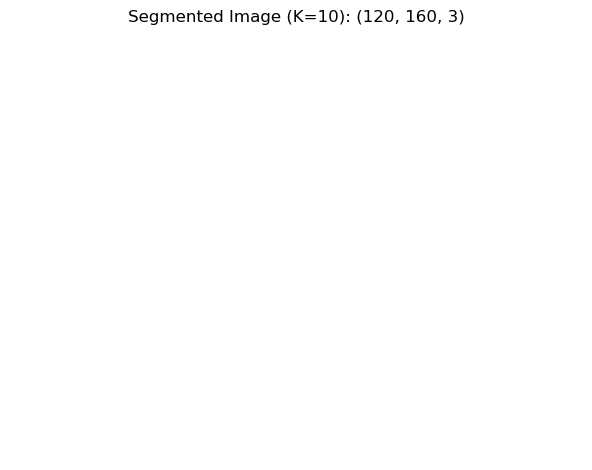

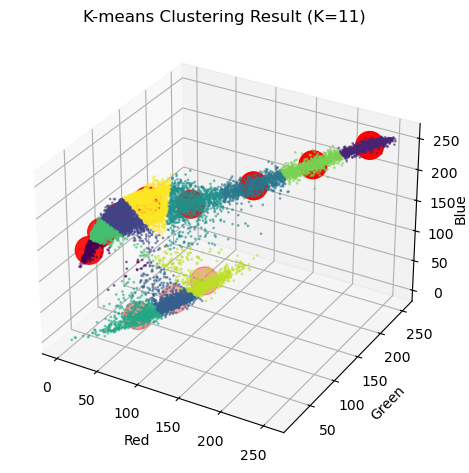

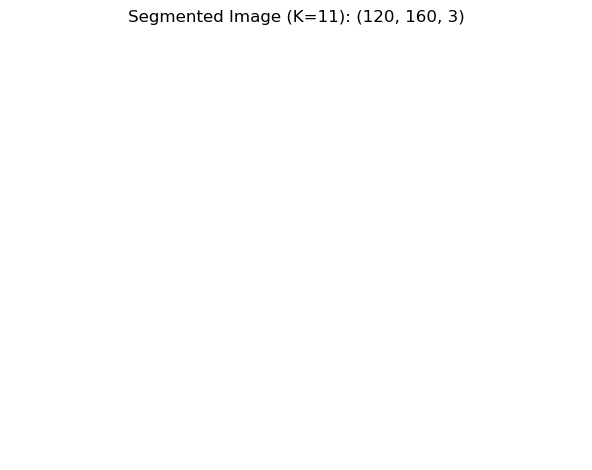

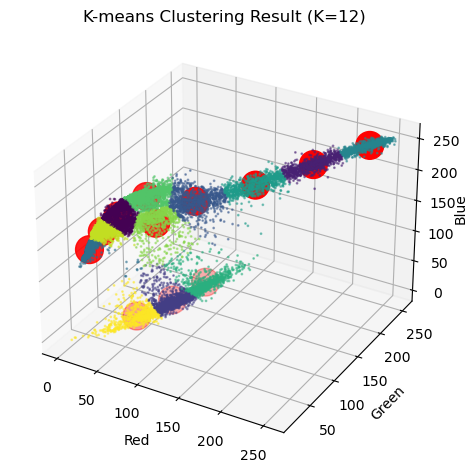

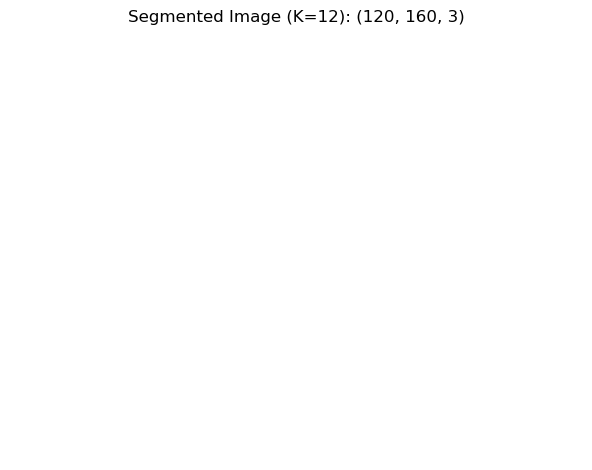

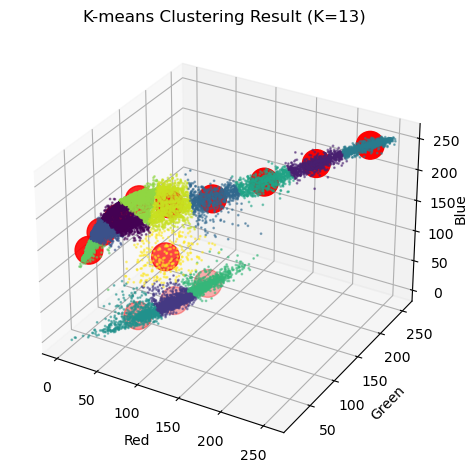

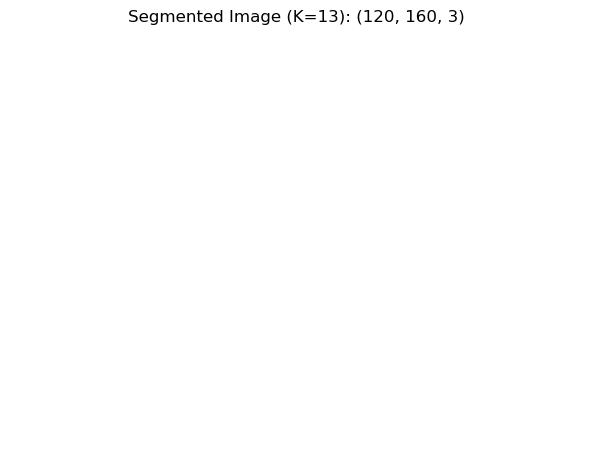

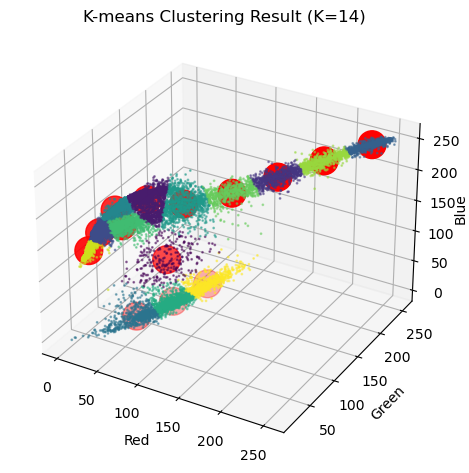

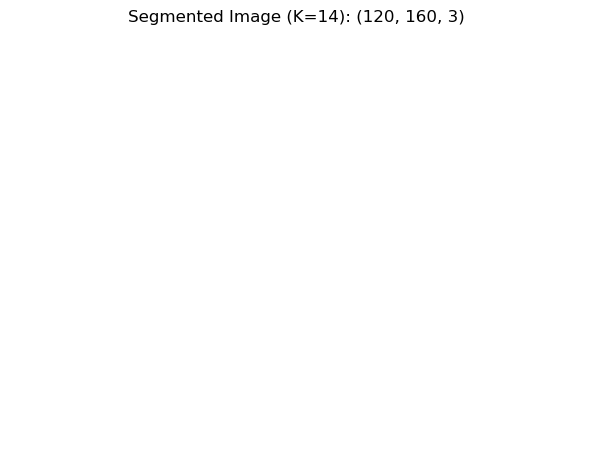

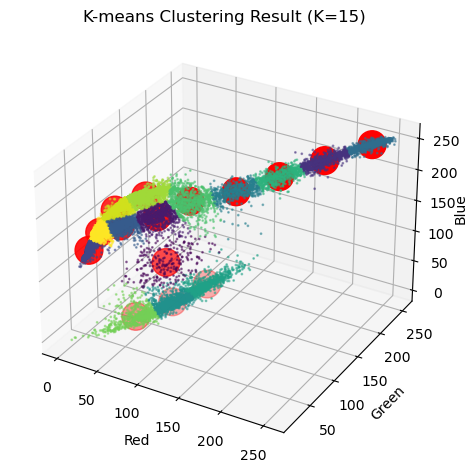

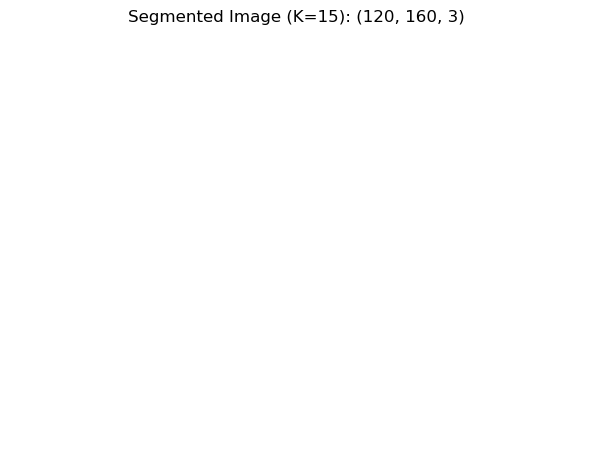

In [50]:
# Reshape the data to a matrix of total_num_pixels x 3
landscape_image_path = './data/landscape.jpg'  # Update with the correct path
landscape_image = plt.imread(landscape_image_path)
landscape_data = landscape_image.reshape((-1, 3))

# Print the shape of the data and the min and max values of the pixels
print("Shape of the data:", landscape_data.shape)
print("Min pixel value:", np.min(landscape_data))
print("Max pixel value:", np.max(landscape_data))

# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):
    # Define the K-means model
    kmeans_landscape = KMeans(n_clusters=k, n_init=10, random_state=1234)
    # Fit the model to the data
    kmeans_landscape.fit(landscape_data)
    # Get the cluster centers
    kmeans_landscape_centroids = kmeans_landscape.cluster_centers_

    # Extarct the color values of the centers
    colors_landscape = np.clip(kmeans_landscape_centroids, 0, 1)  # Ensure values are within [0, 1]
    # Reshape the data to the original image shape
    segmented_image_landscape = colors_landscape[kmeans_landscape.labels_].reshape(landscape_image.shape)
    # Update the inertia
    inertia.append(kmeans_landscape.inertia_)
    # Plot the scatter plot and the ricolored imag
    scatter_plot(landscape_data, kmeans_landscape.labels_, kmeans_landscape_centroids,
                 title=f"K-means Clustering Result (K={k})",)

    # Plot the recolored image
    img_plot(segmented_image_landscape, title=f"Segmented Image (K={k})")
   

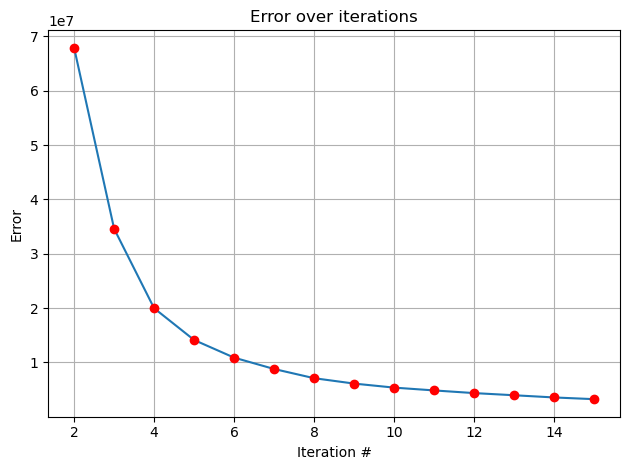

In [51]:

# Plot the error for different values of k

# Define a range of k values
k_values = range(2, 16)

# Initialize an empty list to store errors
kmeans_errors_landscape = []

# Iterate over different values of k
for k in k_values:
    # Define the K-means model
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)

    # Fit the model to the data
    kmeans.fit(landscape_data)

    # Append the error to the list
    kmeans_errors_landscape.append(kmeans.inertia_)

# Plot the error over iterations
error_plot(np.array(kmeans_errors_landscape), labels=k_values)


In [52]:
# Load sample data
data = np.load('data/moon_data.npz') 

# Extract data
x = data['X']
labels_true = data['labels_true']

In [53]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='single')
# Fit the model to the data
agg_clustering.fit(x)
# Compute the number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(agg_clustering.labels_)) - (1 if -1 in agg_clustering.labels_ else 0)
# Print the results
print(f'Estimated number of clusters: {n_clusters_}')

Estimated number of clusters: 2


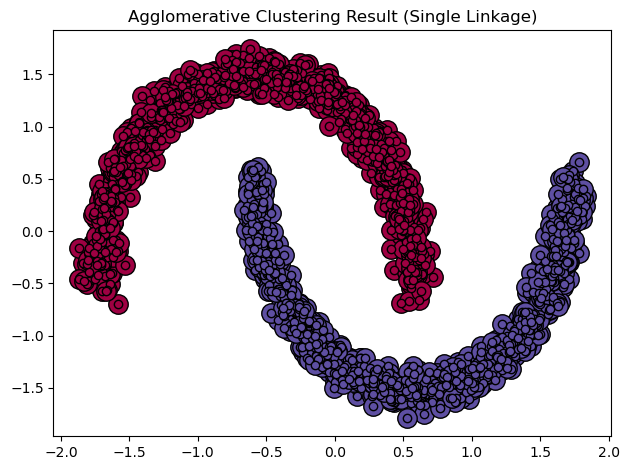

In [54]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(agg_clustering.labels_, x, title="Agglomerative Clustering Result (Single Linkage)")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


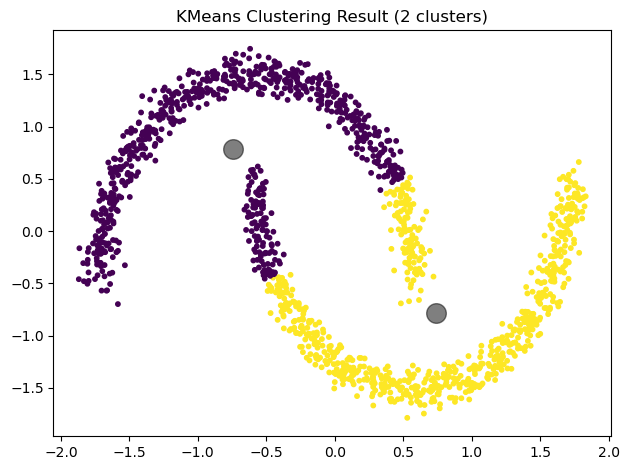

In [55]:
# Define the K-means model
kmeans_b2 = KMeans(n_clusters=2, n_init=10, random_state=1234)
# Fit the model to the data
kmeans_b2.fit(x)
# Get the cluster centers
kmeans_b2_centers = kmeans_b2.cluster_centers_

# Extarct the color values of the centers
colors_b2 = np.clip(kmeans_b2_centers, 0, 1) 
# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x, kmeans_b2.labels_, kmeans_b2_centers, title="KMeans Clustering Result (2 clusters)")

---